## Retail Assessment :  
#### Dated: 12.July.2020
#### Author: Raghav Arora

#### Objective: <br> <ol><li> Select the best performing products as to optimise the storage space.</li><br><li> Predict the demand for products as to ensure fast delivery in future</li></ol>

### Installing necessary python modules

In [2]:
import pandas as pd, datetime,  numpy as np
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### Importing the dataset

In [3]:
data =  pd.read_csv('data.csv', encoding = "ISO-8859-1", low_memory  = False)

## 1. Data Exploration and Cleaning

### Previewing the dataset

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### Findings: Quantity and Unit Price has negative values, as per my understanding of the retail dataset, these cases can be assumed as Returns.

### Outliers Detection

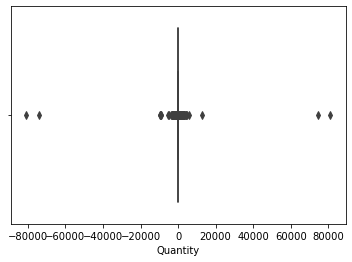

In [6]:
import seaborn as sns
sns.boxplot(x=data['Quantity'])

In [7]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(data['Quantity']))
print(z)
threshold = 5
print(np.where(z > threshold))


[0.01628867 0.01628867 0.00711777 ... 0.02545958 0.02545958 0.03004503]
(array([  4287,   4850,   4945,   4946,   6365,  19871,  19980,  25920,
        32671,  40060,  50849,  52133,  52134,  52709,  52710,  52711,
        52771,  61619,  61624,  63444,  65063,  74614,  74615,  80742,
        82205,  82794,  82795,  86503,  86504,  86505,  87631,  90259,
        91772,  97432,  99936, 109467, 109469, 113580, 114539, 115488,
       115505, 115807, 115810, 115818, 121857, 125281, 125282, 131399,
       139503, 142700, 142702, 142749, 150272, 151033, 154571, 156350,
       160142, 160143, 160144, 160145, 160541, 160542, 160543, 160545,
       160546, 169123, 170511, 170513, 174654, 177702, 185113, 185919,
       186820, 187609, 201149, 203751, 203752, 203761, 206121, 208170,
       220843, 221186, 221722, 221744, 223446, 224419, 225528, 225529,
       225530, 229728, 234739, 234740, 234764, 234765, 242906, 250766,
       253989, 263884, 263885, 270885, 270886, 282289, 284437, 284452,
    

### Checking missing values

In [8]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Quantum of missing values in %

In [9]:
print('Number of rows with blank Customer IDs:',round((data['CustomerID'].isna().sum() * 100)/len(data),2))
print('Number of rows with Description:',round((data['Description'].isna().sum() * 100)/len(data),2))


Number of rows with blank Customer IDs: 24.93
Number of rows with Description: 0.27


#### Countries

In [10]:
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

#### Cases with Unit price <=0

In [11]:
((data['UnitPrice'] <= 0).sum()*100)/len(data)

0.46446912673530055

#### Cases with Quantity <=0

In [12]:
((data['Quantity'] <= 0).sum()*100)/len(data)

1.9604767590130445

#### Cases with Quantity <=0 OR Unit price <=0

In [13]:
(((data['Quantity'] <= 0) | (data['UnitPrice'] <= 0)).sum()*100)/len(data)

2.178410028251976

#### Cases with Quantity <=0 OR Unit price <=0 OR Quantity against each stock in an invoice >=2000

In [14]:
(((data['Quantity'] <= 0) | (data['UnitPrice'] <= 0) | (data['Quantity'] > 2000)).sum()*100)/len(data)

2.182100684801323

#### Cases with Quantity <=0 OR Unit Price <=0 OR Blank Customer ID

In [15]:
(((data['Quantity'] <= 0) | (data['UnitPrice'] <= 0) | (data['CustomerID'].isna() ==  True)).sum()*100)/len(data)

26.577340475983974

### Cleaning the data

### The dataset contains rows where the Quantity < 0, (these are either discounts or returns).

#### Also, unit price has to be greater than 0, in the case of purchase

In [16]:
data_purchased=data.loc[(data['UnitPrice']>0) & (data['Quantity']>0) & (data['Quantity']<=2000)]

In [17]:
len(data_purchased)

530084

In [18]:
data_purchased['InvoiceDate'] = pd.to_datetime(data_purchased['InvoiceDate'])

In [19]:
data_purchased.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [20]:
len(data_purchased.drop_duplicates())

524858

In [21]:
len(data_purchased[['InvoiceNo', 'StockCode' ]].drop_duplicates())

519582

#### Calculating Total Amount against Stock in an invoice

In [22]:
data_purchased['Amount'] = data_purchased['Quantity'] * data_purchased['UnitPrice']

## 2.  Select the best performing products as to optimise the storage space.

#### Ranking the Stock based on the sold amount

In [23]:
data_purchased_stockwise_amount=data_purchased.groupby(['StockCode','Description']).agg({'Amount':sum}).sort_values(by='Amount', ascending =False)


#### Top n Stocks

In [24]:
n=5

In [25]:
data_purchased_stockwise_amount.head(n)

,,Amount
StockCode,Description,
DOT,DOTCOM POSTAGE,206248.77
22423,REGENCY CAKESTAND 3 TIER,174484.74
85123A,WHITE HANGING HEART T-LIGHT HOLDER,104340.29
47566,PARTY BUNTING,99504.33
85099B,JUMBO BAG RED RETROSPOT,94340.05


#### Exporting the data

In [26]:
data_purchased_stockwise_amount.to_csv('outputs/data_purchased_stockwise_amount.csv')

#### Top Stocks on the basis of Sold Amount (Country wise)

In [27]:
data_purchased_stockwise_amount_country_wise=data_purchased.groupby(['Country','StockCode','Description']).agg({'Amount':sum}).sort_values(by='Amount', ascending =False)
# 

In [28]:
data_purchased_stockwise_amount_country_wise['Rank']=data_purchased_stockwise_amount_country_wise.groupby('Country').rank(ascending=False)

#### Top n stocks by country

In [29]:
data_purchased_stockwise_amount_country_wise.loc[data_purchased_stockwise_amount_country_wise["Rank"]<=n]

Amount  Rank
Country        StockCode Description                                        
United Kingdom DOT       DOTCOM POSTAGE                      206248.77   1.0
               22423     REGENCY CAKESTAND 3 TIER            142273.29   2.0
               85123A    WHITE HANGING HEART T-LIGHT HOLDER   98545.24   3.0
               47566     PARTY BUNTING                        93658.53   4.0
               85099B    JUMBO BAG RED RETROSPOT              86471.34   5.0
...                                                                ...   ...
Saudi Arabia   22555     PLASTERS IN TIN STRONGMAN               19.80   2.0
               22553     PLASTERS IN TIN SKULLS                  19.80   2.0
               22361     GLASS JAR DAISY FRESH COTTON WOOL       17.70   5.0
               22362     GLASS JAR PEACOCK BATH SALTS            17.70   5.0
               22363     GLASS JAR MARMALADE                     17.70   5.0

[185 rows x 2 columns]

##### Exporting the data

In [30]:
data_purchased_stockwise_amount_country_wise.to_csv('outputs/data_purchased_stockwise_amount_country_wise.csv')

## 3.  Predict the demand for products as to ensure fast delivery in future

### Preparing time series data for forecasting the demand

##### Extracting date from datetime

In [31]:
data_purchased['Date']=data_purchased['InvoiceDate'].dt.date

##### Casting date as Year-Month

In [32]:
data_purchased['Year_month']=data_purchased['InvoiceDate'].dt.strftime('%Y%m')

#### Creating timeseries data ( 'Stock-Decsription', 'Year-month') wise sold quantity

In [33]:
data_purchased_stock_ts=data_purchased.groupby(['Description', 'Year_month']).agg({'Quantity':sum}).reset_index()

In [34]:
data_purchased_stock_ts_reshaped=data_purchased_stock_ts.loc[data_purchased_stock_ts['Quantity'] > 6].pivot_table(index='Description',columns='Year_month',values='Quantity', aggfunc=sum)

In [35]:
data_purchased_stock_ts_reshaped

Year_month,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
Description,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,16.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,9.0,NaN,47.0,49.0
50'S CHRISTMAS GIFT BAG LARGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,331.0,999.0,496.0,63.0
DOLLY GIRL BEAKER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,955.0,625.0,558.0,167.0,80.0
I LOVE LONDON MINI BACKPACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.0,60.0,156.0,26.0
NINE DRAWER OFFICE TIDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,18.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZINC T-LIGHT HOLDER STARS SMALL,NaN,NaN,NaN,NaN,327.0,1339.0,384.0,473.0,468.0,610.0,559.0,768.0,161.0
ZINC TOP 2 DOOR WOODEN SHELF,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZINC WILLIE WINKIE CANDLE STICK,226.0,118.0,140.0,60.0,118.0,115.0,138.0,112.0,150.0,365.0,598.0,625.0,169.0


In [36]:
data_purchased_stock_ts_reshaped['Not Blank']=data_purchased_stock_ts_reshaped.notnull().sum(axis=1)

In [37]:
data_purchased_stock_ts_reshaped.head(5)

Year_month,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112,Not Blank
Description,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,16.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,9.0,NaN,47.0,49.0,5
50'S CHRISTMAS GIFT BAG LARGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,331.0,999.0,496.0,63.0,5
DOLLY GIRL BEAKER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,955.0,625.0,558.0,167.0,80.0,6
I LOVE LONDON MINI BACKPACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.0,60.0,156.0,26.0,4
NINE DRAWER OFFICE TIDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,18.0,9.0,3


In [38]:
data_purchased_stock_ts_reshaped.loc[data_purchased_stock_ts_reshaped['Not Blank']>6]

Year_month,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112,Not Blank
Description,,,,,,,,,,,,,,
OVAL WALL MIRROR DIAMANTE,22.0,23.0,17.0,16.0,25.0,44.0,17.0,18.0,11.0,NaN,11.0,21.0,7.0,12
SET 2 TEA TOWELS I LOVE LONDON,310.0,430.0,229.0,1111.0,332.0,317.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,7
SPACEBOY BABY GIFT SET,NaN,NaN,NaN,144.0,43.0,50.0,33.0,24.0,15.0,55.0,60.0,61.0,14.0,10
10 COLOUR SPACEBOY PEN,583.0,284.0,247.0,409.0,297.0,636.0,691.0,471.0,614.0,578.0,839.0,805.0,110.0,13
12 COLOURED PARTY BALLOONS,62.0,80.0,80.0,221.0,154.0,285.0,220.0,187.0,155.0,171.0,166.0,330.0,44.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZINC METAL HEART DECORATION,530.0,318.0,440.0,292.0,330.0,412.0,352.0,446.0,535.0,527.0,911.0,782.0,69.0,13
ZINC SWEETHEART WIRE LETTER RACK,NaN,NaN,NaN,NaN,40.0,37.0,9.0,47.0,35.0,26.0,22.0,40.0,7.0,9
ZINC T-LIGHT HOLDER STAR LARGE,NaN,NaN,NaN,NaN,55.0,423.0,185.0,116.0,333.0,230.0,399.0,233.0,86.0,9


#### Declaring the output dataframe

In [39]:
pred_stock =pd.DataFrame()
pred_stock.index.name = 'Description'
pred_stock['Tplusone']=''
pred_stock['Tplustwo']=''
pred_stock['Tplusthree']=''

### Forecasting demand
<br>Points to be considered:
<ol><li>We have considered Exponential Smoothing for forecasting demand</li>
    <li>The smoothing level (Alpha) and smoothing slope (beta) are taken as default (alpha = 0.8, beta = 0.2)</li>
    <li>The stock which sold for more than 6 months were considered.</li></ol>

In [40]:
for i in data_purchased_stock_ts_reshaped.loc[data_purchased_stock_ts_reshaped['Not Blank']>6].index.unique():
    
    X = data_purchased_stock_ts[['Year_month','Quantity']].loc[data_purchased_stock_ts['Description']==i].set_index(
'Year_month')
    fit2 = Holt(np.asarray(X), exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.3, optimized=False)
    predict=fit2.forecast(3)
    A=list(predict)
    pred_stock.loc[i]=A

#### Predicted quantities (Stock Description wise) : for 2012 - Jan, Feb, Mar

In [41]:
pred_stock.head(10)

,Tplusone,Tplustwo,Tplusthree
Description,,,
OVAL WALL MIRROR DIAMANTE,11.085631,11.798827,12.557906
SET 2 TEA TOWELS I LOVE LONDON,141.574514,134.007979,126.845841
SPACEBOY BABY GIFT SET,28.391734,28.956269,29.532030
10 COLOUR SPACEBOY PEN,237.399944,207.775960,181.848609
12 COLOURED PARTY BALLOONS,106.356087,103.824257,101.352697
12 DAISY PEGS IN WOOD BOX,4.169816,3.271071,2.566037
12 EGG HOUSE PAINTED WOOD,8.801522,9.279096,9.782584
12 IVORY ROSE PEG PLACE SETTINGS,54.695776,51.752072,48.966797
12 MESSAGE CARDS WITH ENVELOPES,179.914689,196.854930,215.390215


#### Exporting the result

In [42]:
pred_stock.to_csv('outputs/Stock_Wise_Predicted_quant.csv')

## End of the Assessment